## Exercise - Knowledge Base Agent - STARTER  
In this exercise, you’ll implement and evaluate a RAG (Retrieval-Augmented Generation) pipeline, using RAGAS metrics and MLflow for logging the process.

Challenge

Your task is to create a LangGraph Workflow that includes:

A RAG pipeline for information retrieval.
An LLM-based judge for evaluation.
RAGAS metrics for quality assessment.
MLflow logging for observability.
The workflow should:

Retrieve, augment, and generate answers.
Evaluate the answers using RAGAS.
Log performance metrics in MLflow.  
## 0. Import the necessary libs

In [13]:
import mlflow
from mlflow import log_params, log_metrics
from typing import List, Dict
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
# this one 
from langchain_chroma import Chroma

from langchain_community.document_loaders import PyPDFLoader
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from langchain.prompts import ChatPromptTemplate
from ragas import evaluate
from datasets import Dataset
from IPython.display import Image, display

## 1. Instantiate Chat Model with your API Key  
To be able to connect with OpenAI, you need to instantiate an ChatOpenAI client passing your OpenAI key.

You can pass the api_key argument directly.

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key="voc-",
)

In [14]:
from dotenv import load_dotenv
load_dotenv()

False

In [15]:
# TODO - Instantiate your chat model
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
   # api_key = "YOUR_API_KEY_HERE",   # in my venv
)

In [16]:
# TODO - Instantiate your llm as judge model
# This will evaluate the responses
llm_judge = ChatOpenAI(
    model="gpt-4o",
    temperature=0.0,
  #  api_key = "YOUR_API_KEY_HERE",   # in my venv
)

In [17]:
# TODO - Instantiate your embeddings model
embeddings_fn = OpenAIEmbeddings(
    model="text-embedding-3-large"
  #  api_key = "YOUR_API_KEY_HERE",   # in my venv
)

## MLFlow

In [18]:
mlflow.set_experiment("udacity")

<Experiment: artifact_location='file:///C:/PythonProjects/Project01/mlruns/222450339919689852', creation_time=1760373891487, experiment_id='222450339919689852', last_update_time=1760373891487, lifecycle_stage='active', name='udacity', tags={}>

In [19]:
with mlflow.start_run(run_name="l4_exercise_02") as run:
    log_params(
        {
            "embeddings_model":embeddings_fn.model,
            "llm_model": llm.model_name,
            "llm_judge_model": llm_judge.model_name,
        }
    )
    print(run.info)

<RunInfo: artifact_uri='file:///C:/PythonProjects/Project01/mlruns/222450339919689852/532aaa354795418da1bc8e9bc9d9879b/artifacts', end_time=None, experiment_id='222450339919689852', lifecycle_stage='active', run_id='532aaa354795418da1bc8e9bc9d9879b', run_name='l4_exercise_02', start_time=1760374375512, status='RUNNING', user_id='brian.westerman'>


In [20]:
mlflow_run_id = run.info.run_id

In [21]:
mflow_client = mlflow.tracking.MlflowClient()

In [22]:
mflow_client.get_run(mlflow_run_id)

<Run: data=<RunData: metrics={}, params={'embeddings_model': 'text-embedding-3-large',
 'llm_judge_model': 'gpt-4o',
 'llm_model': 'gpt-4o-mini'}, tags={'mlflow.runName': 'l4_exercise_02',
 'mlflow.source.name': 'C:\\PythonProjects\\Project01\\.venv\\Lib\\site-packages\\ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'brian.westerman'}>, info=<RunInfo: artifact_uri='file:///C:/PythonProjects/Project01/mlruns/222450339919689852/532aaa354795418da1bc8e9bc9d9879b/artifacts', end_time=1760374375547, experiment_id='222450339919689852', lifecycle_stage='active', run_id='532aaa354795418da1bc8e9bc9d9879b', run_name='l4_exercise_02', start_time=1760374375512, status='FINISHED', user_id='brian.westerman'>, inputs=<RunInputs: dataset_inputs=[], model_inputs=[]>, outputs=<RunOutputs: model_outputs=[]>>

## 3. Load and Process Documents

In [24]:
# Initialize vector store
vector_store = Chroma(
    collection_name="udacity",
    embedding_function=embeddings_fn
)

# Load and process PDF documents
file_path = "Arcadia-30_Grayscale.pdf"
loader = PyPDFLoader(file_path)

pages = []
for page in loader.load():
    pages.append(page)

# Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, 
    chunk_overlap=200
)
all_splits = text_splitter.split_documents(pages)

# Store document chunks in the vector database
_ = vector_store.add_documents(documents=all_splits)


## 4. Define State Schema
We define a State Schema for managing:  

MLFlow Run id  
User query  
Ground Truth  
Retrieved documents  
Generated answer  
Evaluation Report  
run_id(str), ground_truth(str), evaluation(Dict),vquestion(str), documents(List) and answer(str)

In [25]:
# TODO - Create your state schema
class State(MessagesState):
    run_id: str
    question: str
    ground_truth: str
    documents: List[Document]
    answer: str
    evaluation: Dict
    

## 5. RAG Nodes  
The agent should:  

fetch relevant document chunks based on the user query  
combine the retrieved documents and use them as context  
invoke the LLM to generate a response  
evaluate the pipeline based on the ground_truth

In [26]:
def retrieve(state: State):
    question = state["question"]
    retrieved_docs = vector_store.similarity_search(question)
    return {"documents": retrieved_docs}

In [27]:
def augment(state: State):
    question = state["question"]
    documents = state["documents"]
    docs_content = "\n\n".join(doc.page_content for doc in documents)

    template = ChatPromptTemplate([
        ("system", "You are an assistant for question-answering tasks."),
        ("human", "Use the following pieces of retrieved context to answer the question. "
                "If you don't know the answer, just say that you don't know. " 
                "Use three sentences maximum and keep the answer concise. "
                "\n# Question: \n-> {question} "
                "\n# Context: \n-> {context} "
                "\n# Answer: "),
    ])

    messages = template.invoke(
        {"context": docs_content, "question": question}
    ).to_messages()

    return {"messages": messages}

In [28]:
def generate(state: State):
    ai_message = llm.invoke(state["messages"])
    return {"answer": ai_message.content, "messages": ai_message}

In [29]:
def evaluate_rag(state: State):
    question = state["question"]
    documents = state["documents"]
    answer = state["answer"]
    ground_truth = state["ground_truth"]
    dataset = Dataset.from_dict(
        {
            "question": [question],
            "answer": [answer],
            "contexts": [[doc.page_content for doc in documents]],
            "ground_truth": [ground_truth]
        }
    )

    evaluation_results = evaluate(
        dataset=dataset,
        llm=llm_judge
    )
    print(evaluation_results)

    # TODO - Log metrics in MLflow
    # The evaluation_results output value is a list
    # Example: evaluation_results["faithfulness"][0]
    with mlflow.start_run(state["run_id"]):
        log_metrics({
            "faithfulness": evaluation_results["faithfulness"][0],
            "context_precision": evaluation_results["context_precision"][0],
            "context_recall": evaluation_results["context_recall"][0],
            "answer_relevancy": evaluation_results["answer_relevancy"][0],
        })

    return {"evaluation": evaluation_results}

## 6. Build the LangGraph Workflow

In [30]:
# TODO - add all the nodes and edges
workflow = StateGraph(State)

workflow.add_node("retrieve", retrieve)
workflow.add_node("augment", augment)
workflow.add_node("generate", generate)
workflow.add_node("evaluate_rag", evaluate_rag)

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "augment")
workflow.add_edge("augment", "generate")
workflow.add_edge("generate", "evaluate_rag")
workflow.add_edge("evaluate_rag", END)

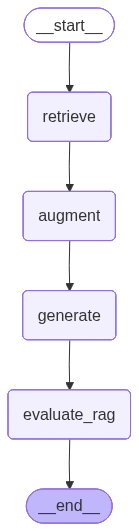

In [31]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

## 7. Invoke the Workflow with a Query

In [32]:
reference = [
    {
        "question": "What are Open source models?",
        "ground_truth": "Open-source models are AI or machine learning " 
                        "models whose code, architecture, and in some cases, " 
                        "training data and weights, are publicly available for " 
                        "use, modification, and distribution. They enable " 
                        "collaboration, transparency, and innovation by allowing " 
                        "developers to fine-tune, deploy, or improve them without " 
                        "proprietary restrictions.",
    }
]
# should fix these to better represent the pdf i used instead of the one they shared

In [33]:
output = graph.invoke(
    {
        "question": reference[0]["question"],
        "ground_truth": reference[0]["ground_truth"],
        "run_id": mlflow_run_id
    }
)



Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


{'answer_relevancy': 0.9978, 'context_precision': 0.0000, 'faithfulness': 0.3333, 'context_recall': 0.0000}


## 8. Inspect in MLFlow

In [35]:
# TODO - Get MLFlow Run with .get_run()
mflow_client.get_run(mlflow_run_id)

<Run: data=<RunData: metrics={'answer_relevancy': 0.9978423662562973,
 'context_precision': 0.0,
 'context_recall': 0.0,
 'faithfulness': 0.3333333333333333}, params={'embeddings_model': 'text-embedding-3-large',
 'llm_judge_model': 'gpt-4o',
 'llm_model': 'gpt-4o-mini'}, tags={'mlflow.runName': 'l4_exercise_02',
 'mlflow.source.name': 'C:\\PythonProjects\\Project01\\.venv\\Lib\\site-packages\\ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'brian.westerman'}>, info=<RunInfo: artifact_uri='file:///C:/PythonProjects/Project01/mlruns/222450339919689852/532aaa354795418da1bc8e9bc9d9879b/artifacts', end_time=1760375409285, experiment_id='222450339919689852', lifecycle_stage='active', run_id='532aaa354795418da1bc8e9bc9d9879b', run_name='l4_exercise_02', start_time=1760374375512, status='FINISHED', user_id='brian.westerman'>, inputs=<RunInputs: dataset_inputs=[], model_inputs=[]>, outputs=<RunOutputs: model_outputs=[]>>

## 9. Experiment  
Now that you understood how it works, experiment with new things.
  
Change RAG parameters: embedding model, chunk_size, chunk_overlap...  
Create multiple runs  
Improve your reference with more questions and ground_truth answers  
Use the results to understand what are the best parameters  
Create an Agent that picks the best combination